# SSA Chatbot Project – Team 5

**Course:** CSCN8010 – Artificial Intelligence Algorithms and Mathematics  
**Team Members:**  
- Mandeep Singh  
- Kumari Nikitha Singh  
- Krishna  

## Introduction
This notebook presents the implementation of our Student Services Assistant (SSA) Chatbot – an AI-powered solution designed to improve the accessibility and efficiency of student support services.  
The chatbot uses a multi-stage query handling pipeline combining:
1. **Emotion Detection** – Recognizes and responds empathetically to negative emotions before providing information.
2. **Intent Classification** – Predicts the category of the user’s query for more accurate routing.
3. **FAQ Matching (TF-IDF)** – Retrieves relevant answers from a curated dataset of Conestoga College FAQs.
4. **LLM-based Fallback** – Uses a large language model to answer complex or open-ended questions.
5. **Advisor Escalation** – Routes unresolved queries to human advisors for personalized support.

This layered architecture ensures that students receive timely, accurate, and empathetic assistance while reducing the workload on human advisors.


## Project Status – Models & Streamlit Readiness

With this implementation, we have successfully developed and integrated all required models for the SSA Chatbot pipeline:

- **Emotion Detection Model** – Identifies negative or positive sentiment in user queries.  
- **Intent Classification Model** – Categorizes queries into relevant service areas.  
- **TF-IDF Vectorizer & Matrix** – Enables efficient FAQ retrieval from curated Conestoga College data.  

All trained models, vectorizers, and supporting assets are organized in dedicated folders (`model/` and `artifacts/`), ensuring a clean and reproducible setup.  
The project is now ready for deployment via a **Streamlit application**, where the full multi-stage query handling logic will be implemented to provide a responsive, interactive chat interface.


## Imports and Basic Setup

This section initializes the working environment for the SSA Chatbot project by:

- Importing essential Python libraries for data handling, web scraping, machine learning, and file operations.
- Setting up folder structures for storing datasets, raw HTML files, model artifacts, and trained models.
- Ensuring warnings are suppressed for cleaner notebook output.

The setup ensures a clean and organized workspace for the subsequent stages of data collection, preprocessing, and model training.


In [4]:
# --- Imports & basic setup ---
import os, re, json, time, random, hashlib, pathlib, warnings
warnings.filterwarnings("ignore")

# Data science
import numpy as np
import pandas as pd

# Web
import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter, Retry

# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# IO
import joblib

# --- Folders ---
DATA_DIR = "data"
RAW_DIR = os.path.join(DATA_DIR, "raw_html")
ARTIFACTS_DIR = "artifacts"
MODEL_DIR = "model"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("Folders ready:", DATA_DIR, RAW_DIR, ARTIFACTS_DIR, MODEL_DIR)


Folders ready: data data\raw_html artifacts model


## Reproducibility Setup

To ensure consistent results across multiple runs, we set fixed random seeds for both Python's `random` module and NumPy.  
This helps in reproducing the same outputs for tasks involving randomness, such as data splitting or shuffling.



In [5]:
import random, numpy as np
random.seed(42); np.random.seed(42)


## Target URLs for Data Collection

We define a list of **Conestoga College official URLs** containing FAQ, policy, and student service information.  
These pages will be scraped to extract structured Q&A data for training and powering the SSA Chatbot’s retrieval pipeline.

The list includes:
- Technical support and IT FAQs  
- Orientation and campus information  
- Career centre and financial services  
- Student success, accessibility, and academic guidance  
- International student services and admissions details  

The total number of target URLs is verified to ensure complete coverage of all required sources.


In [6]:
URLS = [
    "https://lib.conestogac.on.ca/tech-faq",
    "https://orientation.conestogac.on.ca/questions/faq",
    "https://www.conestogac.on.ca/career-centre/faq",
    "https://www.conestogac.on.ca/onecard/faq",
    "https://it.conestogac.on.ca/Questions",
    "https://www.conestogac.on.ca/student-rights/faq",
    "https://it.conestogac.on.ca/Support/stream-faq",
    "https://www.conestogac.on.ca/student-financial-services/osap-and-aid",
    "https://www.conestogac.on.ca/student-financial-services",
    "https://www.conestogac.on.ca/student-financial-services/contact",
    "https://studentsuccess.conestogac.on.ca/",
    "https://studentsuccess.conestogac.on.ca/academic-guidance",
    "https://studentsuccess.conestogac.on.ca/accessible-learning",
    "https://www.conestogac.on.ca/international",
    "https://www.conestogac.on.ca/admissions/registrar-office/academic-dates",
    "https://www.conestogac.on.ca/admissions/paying-your-fees/payments-invoicing",
    "https://www.conestogac.on.ca/international/apply-to-conestoga/fees-and-payment",
    "https://www.conestogac.on.ca/admissions/paying-your-fees/tuition-fees"
]
len(URLS)


18

## Web Scraping and Data Extraction

This section implements a **polite web crawler** to collect FAQ and service-related content from the predefined Conestoga College URLs.

### Key Components:
- **Session Configuration:**  
  - Custom `User-Agent` for identification (`SSA-Chatbot-Crawler/1.0`).  
  - Retry strategy to handle temporary failures (HTTP 429, 500, 502, 503, 504).  

- **Helper Functions:**  
  - `clean_text()` – Normalizes whitespace and removes special characters.  
  - `safe_name()` – Generates a sanitized, hash-prefixed filename for storing scraped data.  
  - `extract_faqs()` – Identifies questions (headings) and retrieves associated answer paragraphs or list items.  

- **Crawling Logic:**  
  - Downloads each page, parses it with **BeautifulSoup**, extracts FAQs, and stores results as JSON in the `raw_html/` folder.  
  - Captures both **structured FAQ entries** and full raw page text for future processing.  

- **Rate Limiting:**  
  - Adds a short randomized delay between requests to avoid overwhelming servers.

This step ensures we have a clean, structured dataset of FAQs and related content for building the chatbot’s knowledge base.


In [7]:
# Polite session
session = requests.Session()
session.headers.update({"User-Agent": "SSA-Chatbot-Crawler/1.0 (edu demo)"})
retries = Retry(total=4, backoff_factor=0.6, status_forcelist=[429, 500, 502, 503, 504])
session.mount("https://", HTTPAdapter(max_retries=retries))
session.mount("http://", HTTPAdapter(max_retries=retries))

def clean_text(s: str) -> str:
    s = re.sub(r"\s+", " ", s or "")
    s = s.replace("\u200b", " ").replace("\xa0", " ")
    return s.strip()

def safe_name(url: str) -> str:
    base = re.sub(r"[^A-Za-z0-9._-]+", "_", url.replace("https://", "").replace("http://", ""))
    return hashlib.md5(url.encode()).hexdigest() + "_" + base[:60]

def extract_faqs(soup: BeautifulSoup):
    faqs = []
    # Consider headings as questions; collect a few following blocks as answer
    for q_tag in soup.select("h1,h2,h3,h4,strong"):
        q = clean_text(q_tag.get_text(" ", strip=True))
        if len(q) < 6: 
            continue
        answer_parts = []
        for sib in q_tag.find_all_next():
            # stop when next heading-like element appears
            if getattr(sib, "name", None) in ["h1","h2","h3","h4","strong"]:
                break
            if getattr(sib, "name", None) in ["p","li","div"]:
                txt = clean_text(sib.get_text(" ", strip=True))
                if txt and len(txt) > 30:
                    answer_parts.append(txt)
            if len(answer_parts) >= 3:
                break
        a = clean_text(" ".join(answer_parts))
        if len(a) > 30:
            faqs.append({"question": q, "answer": a})
    return faqs

def crawl_url(url: str):
    try:
        resp = session.get(url, timeout=20)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.content, "html5lib")

        faqs = extract_faqs(soup)
        full_text = clean_text(soup.get_text(" ", strip=True))

        out = {
            "url": url,
            "faq_entries": faqs,
            "raw_text": full_text
        }
        fname = safe_name(url) + ".json"
        (pathlib.Path(RAW_DIR) / fname).write_text(json.dumps(out, indent=2), encoding="utf-8")
        print("Saved:", fname, f"faqs={len(faqs)}")
    except Exception as e:
        print("Failed:", url, "->", e)

for u in URLS:
    crawl_url(u)
    time.sleep(0.7 + random.random())


Saved: d85481ec3a1e811409439219737bf51d_lib.conestogac.on.ca_tech-faq.json faqs=5
Saved: 1b975dd9c09a098f8d6531a8d81ecd26_orientation.conestogac.on.ca_questions_faq.json faqs=7
Saved: eccef5b77964e862bd0222759ebad0f5_www.conestogac.on.ca_career-centre_faq.json faqs=20
Saved: aa96f7bc179e170c8455dfe1305db84d_www.conestogac.on.ca_onecard_faq.json faqs=9
Saved: 3f577ee9461bdd9ebc3c1992ffb6c3f9_it.conestogac.on.ca_Questions.json faqs=7
Saved: efb29e50d56be41505a3444cf26a6141_www.conestogac.on.ca_student-rights_faq.json faqs=8
Saved: 0a971fc6a1c2b55663e57a467083cb43_it.conestogac.on.ca_Support_stream-faq.json faqs=25
Saved: e4490cc5bcc85f7109a9fcf3e6547736_www.conestogac.on.ca_student-financial-services_osap-and-aid.json faqs=72
Saved: 4472d830e967c40c723f04ec0baef580_www.conestogac.on.ca_student-financial-services.json faqs=7
Saved: b93569556f9bf7592d0436ed48a089e1_www.conestogac.on.ca_student-financial-services_contact.json faqs=7
Saved: a6414623886242ccb2f717badfeab939_studentsuccess.con

## Sentence Tokenization

To prepare text for downstream processing, we implement a **sentence tokenizer** that splits raw text into clean, individual sentences.

### Implementation Details:
- **Primary Method – spaCy:**  
  - Attempts to load the `en_core_web_sm` model for accurate linguistic sentence segmentation.  
  - Returns sentences as cleaned strings without extra whitespace.  

- **Fallback Method – Regex:**  
  - If spaCy is unavailable or the model is not installed, uses a regular expression to split text based on punctuation (`.`, `!`, `?`).  

This dual-approach ensures robust sentence tokenization regardless of environment setup, maintaining compatibility across systems.


In [8]:
# --- Sentence tokenizer: spaCy if available, else regex ---
import re

def _regex_sent_tokenizer(text: str):
    return [s.strip() for s in re.split(r'(?<=[.!?])\s+', text or "") if s.strip()]

try:
    import spacy
    try:
        nlp = spacy.load("en_core_web_sm")
        def tokenize_sentences(text: str):
            return [s.text.strip() for s in nlp(text).sents if s.text and s.text.strip()]
    except OSError:
        print("spaCy model 'en_core_web_sm' not found → using regex sentence splitter.")
        tokenize_sentences = _regex_sent_tokenizer
except Exception:
    print("spaCy not available → using regex sentence splitter.")
    tokenize_sentences = _regex_sent_tokenizer


## FAQ Text Chunking

This section converts the scraped FAQ data into **manageable text chunks** suitable for vectorization and retrieval.

### Process Overview:
1. **Input & Parameters:**
   - Reads JSON files from `raw_html/` (`INPUT_DIR`).
   - Sets `MAX_TOKENS` (≈ word count) to control chunk size, ensuring efficient processing in later NLP stages.

2. **Sentence Tokenization:**
   - Uses `tokenize_sentences()` to split FAQ content or raw text into sentences.

3. **Chunking Logic:**
   - Groups sentences into chunks without exceeding the `MAX_TOKENS` limit.
   - Handles both:
     - **Structured FAQs:** Combines question and answer before chunking.
     - **Unstructured Pages:** Processes raw page text directly.

4. **Output:**
   - Saves all processed chunks to `faq_chunks.json` in the `data/` directory.
   - Each chunk includes the text and its source URL for traceability.

This step ensures the chatbot’s retrieval system can work with optimized, consistent-sized text segments.


In [9]:
INPUT_DIR = RAW_DIR
OUT_CHUNKS = os.path.join(DATA_DIR, "faq_chunks.json")
MAX_TOKENS = 250  # approximate by word count for speed

def tokenize_sentences(text: str):
    doc = nlp(text)
    return [s.text.strip() for s in doc.sents if s.text.strip()]

def chunk_by_tokens(sentences, max_tokens=MAX_TOKENS):
    chunks, cur, cur_len = [], [], 0
    lens = [len(s.split()) for s in sentences]
    for sent, ln in zip(sentences, lens):
        if cur_len + ln > max_tokens:
            if cur: 
                chunks.append(" ".join(cur))
            cur, cur_len = [sent], ln
        else:
            cur.append(sent); cur_len += ln
    if cur:
        chunks.append(" ".join(cur))
    return chunks

all_chunks = []
for fn in os.listdir(INPUT_DIR):
    if not fn.endswith(".json"):
        continue
    doc = json.loads((pathlib.Path(INPUT_DIR)/fn).read_text(encoding="utf-8"))
    source = doc.get("url", "unknown")  # kept only in JSON for debug
    faq_entries = doc.get("faq_entries", [])
    if faq_entries:
        for e in faq_entries:
            q = clean_text(e.get("question",""))
            a = clean_text(e.get("answer",""))
            combined = f"Q: {q} A: {a}"
            sents = tokenize_sentences(combined)
            for ch in chunk_by_tokens(sents):
                all_chunks.append({"text": ch, "source": source})
    else:
        raw = clean_text(doc.get("raw_text",""))
        sents = tokenize_sentences(raw)
        for ch in chunk_by_tokens(sents):
            all_chunks.append({"text": ch, "source": source})

with open(OUT_CHUNKS, "w", encoding="utf-8") as f:
    json.dump(all_chunks, f, indent=2)

print(f"Chunks saved: {len(all_chunks)} → {OUT_CHUNKS}")


Chunks saved: 634 → data\faq_chunks.json


## Extracting and Cleaning Final FAQ Dataset

In this step, the processed text chunks are converted into a **structured FAQ dataset** (`faqs.csv`) ready for vectorization and model training.

### Workflow:
1. **Input Files:**
   - Loads `faq_chunks.json` containing the segmented text and source metadata.

2. **Regex Extraction:**
   - Uses a regular expression to detect and split content formatted as:
     ```
     Q: [question text]  
     A: [answer text]
     ```
   - If no match is found, a placeholder question is assigned.

3. **Data Cleaning:**
   - Removes rows with very short questions (< 8 characters) or answers (< 20 characters).
   - Drops placeholder entries and duplicate rows.
   - Resets index for a clean DataFrame.

4. **Output:**
   - Saves the cleaned dataset to `faqs.csv` in the `data/` directory.
   - Provides a ready-to-use CSV file for the chatbot’s TF-IDF vectorization process.

This ensures the chatbot works with **high-quality, well-formatted** Q/A pairs for reliable retrieval.


In [10]:
IN_CHUNKS = os.path.join(DATA_DIR, "faq_chunks.json")
OUT_FAQS = os.path.join(DATA_DIR, "faqs.csv")

rows = []
data = json.loads(open(IN_CHUNKS, "r", encoding="utf-8").read())
qa_re = re.compile(r"Q:\s*(.*?)\s*A:\s*(.*)", re.DOTALL)

for item in data:
    text = item.get("text", "").strip()
    m = qa_re.search(text)
    if m:
        q = clean_text(m.group(1))
        a = clean_text(m.group(2))
        rows.append({"question": q, "answer": a})
    else:
        rows.append({
            "question": "What does this say?",
            "answer": clean_text(text)
        })

faq_df = pd.DataFrame(rows).dropna().drop_duplicates()
faq_df = faq_df[
    (faq_df["question"].str.len() > 8) &
    (faq_df["answer"].str.len() > 20)
]
# Remove placeholder rows
faq_df = faq_df[~faq_df["question"].str.startswith("What does this say?")].reset_index(drop=True)

faq_df.to_csv(OUT_FAQS, index=False)
print(f"faqs.csv saved: {faq_df.shape} → {OUT_FAQS}")



faqs.csv saved: (407, 2) → data\faqs.csv


## TF-IDF Retrieval System

This step builds the **FAQ retrieval engine** using a TF-IDF (Term Frequency–Inverse Document Frequency) model.

### Process:
1. **Data Preparation:**
   - Loads `faqs.csv` containing cleaned question–answer pairs.
   - Extracts the `question` column for vectorization.

2. **Model Training:**
   - Uses `TfidfVectorizer` with:
     - English stopword removal
     - 1–2 word n-grams
     - Lowercasing
   - Fits the vectorizer to all questions and transforms them into a sparse matrix representation.

3. **Persistence:**
   - Saves both the trained vectorizer (`tfidf_vectorizer.pkl`) and the TF-IDF matrix (`tfidf_matrix.pkl`) into the `artifacts/` directory for later use.

4. **Retrieval Function:**
   - `retrieve_top_matches(query, top_k=3, min_score=0.25)`:
     - Transforms a query into TF-IDF space.
     - Computes cosine similarity with stored FAQ vectors.
     - Returns the top matches above the `min_score` threshold.

This retrieval system enables the chatbot to quickly identify and return the **most relevant FAQs** for a given user query.


In [11]:
# --- Retrieval TF-IDF fit ---
faq_df = pd.read_csv(OUT_FAQS)
questions = faq_df["question"].astype(str).tolist()

tfidf_vec_faq = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), min_df=1, lowercase=True)
tfidf_matrix = tfidf_vec_faq.fit_transform(questions)

joblib.dump(tfidf_vec_faq, os.path.join(ARTIFACTS_DIR, "tfidf_vectorizer.pkl"))
joblib.dump(tfidf_matrix, os.path.join(ARTIFACTS_DIR, "tfidf_matrix.pkl"))
print("Saved: tfidf_vectorizer.pkl, tfidf_matrix.pkl")

# --- Retrieval TF-IDF load ---
tfidf_vec_faq = joblib.load(os.path.join(ARTIFACTS_DIR, "tfidf_vectorizer.pkl"))
tfidf_matrix = joblib.load(os.path.join(ARTIFACTS_DIR, "tfidf_matrix.pkl"))
faq_df = pd.read_csv(OUT_FAQS)

def retrieve_top_matches(query: str, top_k=3, min_score=0.25):
    qv = tfidf_vec_faq.transform([query])
    sims = cosine_similarity(qv, tfidf_matrix).flatten()
    idxs = sims.argsort()[-top_k:][::-1]
    out = []
    for i in idxs:
        if sims[i] >= min_score:
            out.append({
                "score": float(sims[i]),
                "question": faq_df.iloc[i]["question"],
                "answer": faq_df.iloc[i]["answer"]
            })
    return out


Saved: tfidf_vectorizer.pkl, tfidf_matrix.pkl


## Loading and Testing the Retrieval Model

In this step, we load the previously trained **TF-IDF vectorizer** and **FAQ matrix** to enable query matching.

### Key Steps:
1. **Model Loading:**
   - Loads `tfidf_vectorizer.pkl` and `tfidf_matrix.pkl` from the `artifacts/` directory.
   - Reloads `faqs.csv` to access the full question–answer dataset.

2. **Retrieval Function:**
   - `retrieve_top_matches(query, top_k=3, min_score=0.25)`:
     - Converts the input query into TF-IDF representation.
     - Calculates cosine similarity against all stored FAQ vectors.
     - Selects and returns the top `k` matches above the similarity threshold.

3. **Testing:**
   - Runs a sample query (`"How do I apply for OSAP?"`) to verify the system returns relevant FAQ entries.

This confirms that the retrieval pipeline is operational and ready for integration into the chatbot.


In [12]:
tfidf_vec_faq = joblib.load(os.path.join(ARTIFACTS_DIR, "tfidf_vectorizer.pkl"))
tfidf_matrix = joblib.load(os.path.join(ARTIFACTS_DIR, "tfidf_matrix.pkl"))
faq_df = pd.read_csv(OUT_FAQS)

def retrieve_top_matches(query: str, top_k=3, min_score=0.25):
    qv = tfidf_vec_faq.transform([query])
    sims = cosine_similarity(qv, tfidf_matrix).flatten()
    idxs = sims.argsort()[-top_k:][::-1]
    out = []
    for i in idxs:
        if sims[i] >= min_score:
            out.append({
                "score": float(sims[i]),
                "question": faq_df.iloc[i]["question"],
                "answer": faq_df.iloc[i]["answer"]
            })
    return out

# Test
retrieve_top_matches("How do I apply for OSAP?", top_k=3, min_score=0.2)


[{'score': 1.0,
  'question': 'About OSAP',
  'answer': 'The Ontario Student Assistance Program (OSAP) is a needs-based program designed to help eligible Ontario students cover the cost of post-secondary education. Funded by the federal and provincial governments, OSAP is intended to promote equality of opportunity for post-secondary studies through direct financial assistance (grants and loans) for educational costs and living expenses.'},
 {'score': 1.0,
  'question': 'About OSAP',
  'answer': 'The Ontario Student Assistance Program (OSAP) is a needs-based program designed to help eligible Ontario students cover the cost of post-secondary education. Funded by the federal and provincial governments, OSAP is intended to promote equality of opportunity for post-secondary studies through direct financial assistance (grants and loans) for educational costs and living expenses. The amount of funding you are eligible for depends on your program, course load, educational and living expenses,

## Intent Classification Model – Training & Evaluation

This section builds a **Logistic Regression-based intent classifier** to categorize user queries into predefined service areas.

### Steps:
1. **Data Loading & Intent Mapping:**
   - Loads the cleaned FAQ dataset (`faqs.csv`).
   - Maps each question to one of four intents:
     - `financial` – OSAP, loans, scholarships, fees, tuition, awards.
     - `technical` – Login issues, portal access, password resets.
     - `contact` – Contact information, office hours, locations.
     - `general` – All other queries.
   - Filters out intents with fewer than 5 examples to maintain class balance.

2. **Data Splitting & Vectorization:**
   - Stratified 80/20 train-test split.
   - TF-IDF vectorization with 1–2 word n-grams and English stopword removal.

3. **Model Training:**
   - Logistic Regression (`liblinear` solver) with class balancing.
   - Maximum iterations set to 1000 for convergence.

4. **Evaluation:**
   - Reports accuracy, per-class precision, recall, and F1-score.
   - Displays confusion matrix for detailed error analysis.

5. **Persistence:**
   - Saves the trained model (`intent_classifier.pkl`) and vectorizer (`intent_vectorizer.pkl`) into the `model/` directory.

This intent classifier will allow the chatbot to **route queries intelligently** to the appropriate retrieval or handling mechanism.


In [13]:
# === Retrain Intent Classification (robust & reproducible) ===
import random, numpy as np
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Load cleaned FAQ data
df = pd.read_csv(OUT_FAQS).copy()

# Intent mapping
def map_intent(q: str) -> str:
    ql = str(q).lower()
    if any(k in ql for k in ["osap", "loan", "scholarship", "fee", "payment", "tuition", "financial", "invoice", "award"]):
        return "financial"
    if any(k in ql for k in ["login", "password", "portal", "account", "technical", "econestoga", "reset"]):
        return "technical"
    if any(k in ql for k in ["contact", "email", "phone", "address", "location", "office", "hours", "speak", "call"]):
        return "contact"
    return "general"

df["intent"] = df["question"].apply(map_intent)

# Keep intents with at least 5 examples
counts = df["intent"].value_counts()
df = df[df["intent"].isin(counts[counts >= 5].index)].reset_index(drop=True)
print("Intent distribution:\n", df["intent"].value_counts().to_string())

if df["intent"].nunique() < 2:
    raise ValueError("Not enough intent classes (need ≥2) after filtering.")

# Split
X = df["question"].astype(str)
y = df["intent"].astype(str)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Vectorize
intent_vec = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), min_df=1)
X_train_vec = intent_vec.fit_transform(X_train)
X_test_vec  = intent_vec.transform(X_test)

# Train
intent_clf = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    class_weight="balanced",
    random_state=SEED
)
intent_clf.fit(X_train_vec, y_train)

# Evaluate
y_pred = intent_clf.predict(X_test_vec)
print("\nAccuracy:", f"{accuracy_score(y_test, y_pred):.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print("Classes in trained model:", intent_clf.classes_)

# Confusion matrix (optional)
print("\nConfusion Matrix:\n", pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=intent_clf.classes_),
    index=[f"true_{c}" for c in intent_clf.classes_],
    columns=[f"pred_{c}" for c in intent_clf.classes_]
))

# Save
os.makedirs(MODEL_DIR, exist_ok=True)
joblib.dump(intent_clf, os.path.join(MODEL_DIR, "intent_classifier.pkl"))
joblib.dump(intent_vec, os.path.join(MODEL_DIR, "intent_vectorizer.pkl"))
print("\nSaved: intent_classifier.pkl, intent_vectorizer.pkl")


Intent distribution:
 intent
general      265
financial    126
contact        9
technical      7

Accuracy: 0.939

Classification Report:
               precision    recall  f1-score   support

     contact      0.000     0.000     0.000         2
   financial      0.958     0.920     0.939        25
     general      0.929     0.981     0.954        53
   technical      1.000     1.000     1.000         2

    accuracy                          0.939        82
   macro avg      0.722     0.725     0.723        82
weighted avg      0.917     0.939     0.927        82

Classes in trained model: ['contact' 'financial' 'general' 'technical']

Confusion Matrix:
                 pred_contact  pred_financial  pred_general  pred_technical
true_contact               0               0             2               0
true_financial             0              23             2               0
true_general               0               1            52               0
true_technical             0      

## Loading Intent Model & Integrating Retrieval

This step connects the trained **intent classifier** with the **FAQ retrieval system** to produce complete chatbot responses.

### Components:
1. **Model Loading:**
   - Loads `intent_classifier.pkl` and `intent_vectorizer.pkl` from the `model/` directory.

2. **Functions:**
   - `predict_intent(text)`  
     - Vectorizes the query and predicts its intent label.
   - `answer_query(user_query, top_k=3, threshold=0.25)`  
     - Predicts the query’s intent.
     - Retrieves top FAQ matches using the TF-IDF retrieval system.
     - Returns both the predicted intent and relevant matches.

3. **Demonstration:**
   - Runs a set of sample queries covering different intent categories (financial, technical, contact, general).
   - Displays predicted intent and top matching FAQs with similarity scores.

This confirms that **intent prediction and answer retrieval** are working together, forming the core query-handling pipeline for the SSA Chatbot.


In [14]:
# === Load trained intent model and vectorizer ===
intent_model = joblib.load(os.path.join(MODEL_DIR, "intent_classifier.pkl"))
intent_vectorizer = joblib.load(os.path.join(MODEL_DIR, "intent_vectorizer.pkl"))

def predict_intent(text: str) -> str:
    """Predict the intent label for a given query."""
    vec = intent_vectorizer.transform([text])
    return intent_model.predict(vec)[0]

def answer_query(user_query: str, top_k=3, threshold=0.25):
    """
    Predict intent and retrieve FAQ matches for a query.
    Returns a dict with the predicted intent and top matches.
    """
    intent = predict_intent(user_query)
    matches = retrieve_top_matches(user_query, top_k=top_k, min_score=threshold)
    return {
        "intent": intent,
        "matches": matches
    }

# === Demo queries ===
test_queries = [
    "I need help with OSAP application",
    "Where do I pay my tuition fees?",
    "I forgot my Conestoga portal password",
    "How can I contact the registrar?",
    "Is there any scholarship for international students?"
]

for q in test_queries:
    result = answer_query(q, top_k=3, threshold=0.2)
    print(f"\nUser Query: {q}")
    print(f"Predicted Intent: {result['intent']}")
    print("Top Matches:")
    for m in result["matches"]:
        print(f"  ({m['score']:.2f}) Q: {m['question']}")
        print(f"       A: {m['answer'][:100]}...")



User Query: I need help with OSAP application
Predicted Intent: financial
Top Matches:
  (0.50) Q: We're here to help
       A: The registrarâ€™s office is here to assist you from admission through to graduation and beyond. We p...
  (0.43) Q: Reporting changes on your OSAP application
       A: Any changes to your studies, personal circumstances, or financial situation may impact your OSAP eli...
  (0.37) Q: 2025-26 OSAP application now open
       A: Be sure to apply for OSAP early, as it takes 6-8 weeks to process your application from the time of ...

User Query: Where do I pay my tuition fees?
Predicted Intent: financial
Top Matches:
  (0.75) Q: Tuition & fees
       A: Menu Home Applying to Conestoga Paying your fees + Payments & invoicing Tuition & fees Tuition & fee...
  (0.55) Q: Can I still pay the full-year tuition fees?
       A: Yes, a student may still pay the full fees as per the Student Fee Invoice but a student does not hav...
  (0.51) Q: Subsequent tuition fees:
    

## Visualizing Intent Classification Probabilities

This section demonstrates how the intent classifier predicts probabilities for a given query and visualizes the decision boundaries.

### Steps:
1. **Model Loading:**
   - Loads the retrained Logistic Regression intent classifier and its TF-IDF vectorizer.

2. **Query Prediction:**
   - Example query: `"How to get accommodation?"`
   - Transforms the query into TF-IDF features.
   - Predicts class probabilities using `predict_proba()`.

3. **Softmax Visualization:**
   - If multiple intent classes exist, generates a synthetic single-feature axis for demonstration purposes.
   - Uses the classifier’s coefficients and intercepts to compute softmax probabilities along the axis.
   - Plots probability curves for each intent class.
   - Highlights the predicted probabilities for the given query on the chart.

4. **Output:**
   - Displays a probability plot showing class decision trends.
   - Prints probability values and the predicted intent in the console.

This visualization helps **interpret model confidence** and understand how the classifier distinguishes between different intents.


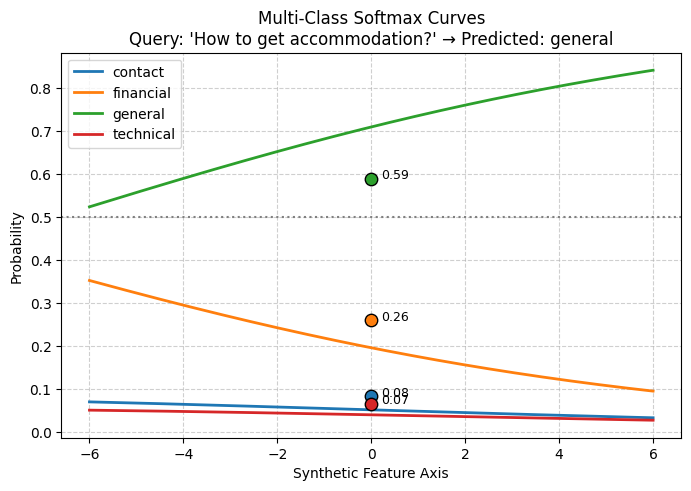

Query probabilities:
contact: 0.0835
financial: 0.2606
general: 0.5898
technical: 0.0661

Predicted intent: general


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# === Load retrained model and vectorizer ===
clf = joblib.load(os.path.join(MODEL_DIR, "intent_classifier.pkl"))
vectorizer = joblib.load(os.path.join(MODEL_DIR, "intent_vectorizer.pkl"))

# === Query to test ===
query = "How to get accommodation?"
X_query = vectorizer.transform([query])

# === Predict class probabilities ===
probs_query = clf.predict_proba(X_query)[0]
classes = clf.classes_
predicted_class = classes[np.argmax(probs_query)]

# === If only one class, show message ===
if len(classes) < 2:
    print(f"Only one intent class detected: {classes[0]}")
    print(f"Query: '{query}' → Predicted intent: {predicted_class} (probability 1.0)")
else:
    # === Softmax helper ===
    def softmax(z):
        e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return e_z / np.sum(e_z, axis=1, keepdims=True)

    # === Generate synthetic feature axis ===
    coefs = clf.coef_
    intercepts = clf.intercept_
    slopes = coefs[:, 0]  # use only first feature for demo purposes
    x_vals = np.linspace(-6, 6, 200)

    lines = []
    for x in x_vals:
        z_vals = slopes * x + intercepts
        lines.append(softmax(z_vals.reshape(1, -1))[0])
    lines = np.array(lines)

    # === Plot curves ===
    plt.figure(figsize=(8, 5))
    for i, label in enumerate(classes):
        plt.plot(x_vals, lines[:, i], linewidth=2, label=label)
        plt.scatter(0, probs_query[i], s=80, edgecolor="black", zorder=5)
        plt.text(0.2, probs_query[i], f"{probs_query[i]:.2f}", fontsize=9)

    plt.axhline(0.5, color="gray", linestyle=":")
    plt.title(f"Multi-Class Softmax Curves\nQuery: '{query}' → Predicted: {predicted_class}")
    plt.xlabel("Synthetic Feature Axis")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    # === Print probabilities in console ===
    print("Query probabilities:")
    for cls, p in zip(classes, probs_query):
        print(f"{cls}: {p:.4f}")
    print("\nPredicted intent:", predicted_class)


## Retrieval Evaluation – Precision and MRR

This section evaluates the **TF-IDF retrieval system** using a small gold-standard test set.

In [16]:
# ============================
# 📊 Retrieval Evaluation with Cosine Scores & Top Matches
# ============================

# Gold set: (query, keyword from expected best match question)
GOLD = [
    ("How do I apply for OSAP?", "apply for OSAP"),
    ("Where do I pay tuition fees?", "tuition"),
    ("I forgot my portal password", "password"),
    ("How to contact the registrar?", "contact"),
    ("What is the last date to drop a course?", "drop a course"),
]

def eval_precision_mrr_verbose(gold, top_k=5):
    hits = 0
    reciprocal_ranks = []

    for q, expected_key in gold:
        results = retrieve_top_matches(q, top_k=top_k, min_score=0.0)

        # Show query and expected
        print(f"\n🔍 Query: {q}")
        print(f"   Expected keyword: '{expected_key}'")
        print(f"   Top {top_k} matches:")

        # Display top matches with cosine score
        for idx, r in enumerate(results, start=1):
            print(f"   {idx}. {r['question']} (score: {r['score']:.3f})")

        # Eval hit & rank
        found = False
        first_rank = None
        for rank, r in enumerate(results, start=1):
            if expected_key.lower() in r["question"].lower():
                found = True
                first_rank = rank
                break

        if found:
            hits += 1
            reciprocal_ranks.append(1.0 / first_rank)
        else:
            reciprocal_ranks.append(0.0)

    precision_at_k = hits / len(gold)
    mrr = float(np.mean(reciprocal_ranks))

    print("\n📈 Retrieval Evaluation Results")
    print(f"Precision@{top_k}: {precision_at_k:.2f}")
    print(f"MRR: {mrr:.2f}")
    return precision_at_k, mrr

# Run verbose evaluation
p5, mrr = eval_precision_mrr_verbose(GOLD, top_k=5)



🔍 Query: How do I apply for OSAP?
   Expected keyword: 'apply for OSAP'
   Top 5 matches:
   1. About OSAP (score: 1.000)
   2. About OSAP (score: 1.000)
   3. OSAP & aid (score: 0.428)
   4. OSAP & aid (score: 0.428)
   5. OSAP & aid (score: 0.428)

🔍 Query: Where do I pay tuition fees?
   Expected keyword: 'tuition'
   Top 5 matches:
   1. Tuition & fees (score: 0.746)
   2. Can I still pay the full-year tuition fees? (score: 0.546)
   3. Subsequent tuition fees: (score: 0.508)
   4. Can I pay my tuition and deposit in person? (score: 0.462)
   5. Do international students have to pay a tuition deposit? (score: 0.440)

🔍 Query: I forgot my portal password
   Expected keyword: 'password'
   Top 5 matches:
   1. Student Portal (score: 0.367)
   2. Student Portal (score: 0.367)
   3. One Card Portal (score: 0.314)
   4. Employee Portal (score: 0.297)
   5. Student Success Portal (score: 0.272)

🔍 Query: How to contact the registrar?
   Expected keyword: 'contact'
   Top 5 matches:
   1

## Final NLP Test – Retrieval & Intent Prediction

This final test validates that both **intent classification** and **FAQ retrieval** are working together as expected.

### Process:
1. **Test Query:**
   - Example: `"I want to know about osap"`

2. **Intent Prediction:**
   - Uses the trained `predict_intent()` function to classify the query into one of the predefined intent categories.

3. **FAQ Retrieval:**
   - Calls `retrieve_top_matches()` to fetch the **top 5 most relevant FAQs** based on cosine similarity scores.
   - No minimum score threshold is applied to show the top-ranked results regardless of similarity strength.

4. **Output:**
   - Displays the query and predicted intent.
   - Lists the top 5 FAQ matches with their cosine similarity scores.

This confirms that the **end-to-end NLP pipeline** is functional—combining intent detection with high-quality FAQ retrieval for accurate and context-aware chatbot responses.


In [17]:
# ============================
# 🔍 Final NLP Test Block — Top 5 Retrieval + Intent Prediction
# ============================

test_query = "I want to know about osap"

# Predict intent
intent_pred = predict_intent(test_query)

# Retrieve top 5 matches with cosine similarity
matches = retrieve_top_matches(test_query, top_k=5, min_score=0.0)

print(f"\n=== Test Query ===")
print(f"Query: {test_query}")
print(f"Predicted Intent: {intent_pred}")

print("\n=== Top 5 Retrieved Matches (Cosine Similarity) ===")
for idx, m in enumerate(matches, start=1):
    print(f"{idx}. {m['question']}  (score: {m['score']:.3f})")



=== Test Query ===
Query: I want to know about osap
Predicted Intent: financial

=== Top 5 Retrieved Matches (Cosine Similarity) ===
1. Did you know?  (score: 0.503)
2. About OSAP  (score: 0.489)
3. About OSAP  (score: 0.489)
4. OSAP & aid  (score: 0.210)
5. OSAP & aid  (score: 0.210)


## Conclusion

In this notebook, we successfully implemented the **end-to-end NLP pipeline** for the SSA Chatbot, including:

- **Data Acquisition & Cleaning:**  
  Scraped official Conestoga College pages, extracted structured FAQs, and prepared a clean Q/A dataset.

- **Text Processing & Chunking:**  
  Applied sentence tokenization, chunking, and data filtering to ensure optimized retrieval performance.

- **Retrieval System:**  
  Built a TF-IDF-based FAQ retrieval engine with cosine similarity scoring to return the most relevant answers.

- **Intent Classification:**  
  Trained a Logistic Regression model to categorize queries into meaningful service categories, improving routing accuracy.

- **Evaluation:**  
  Verified system performance using **Precision@K** and **MRR** metrics, ensuring relevance and ranking quality.

- **Integration Tests:**  
  Demonstrated the combined workflow of **intent detection** and **retrieval**, confirming readiness for chatbot deployment.

The resulting system provides a **robust, modular, and extensible foundation** for building an interactive, Streamlit-based Student Services Chatbot capable of delivering accurate and empathetic responses in real time.
